# Face-to-BMI
***
## Machine Learning II

By Amulya Jayanti | Halleluya Mengesha | Hira Stanley | Sami Naeem | Vaishnavi Kokadwar
  
*May, 2025*
***

# PART 2 - Models

## a) EfficientNet -  Best Model

### Section 0 - Data Preparation

In [ ]:
# !pip install catboost

**Load Libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
    EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
)
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# Regressor imports
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    AdaBoostRegressor, VotingRegressor
)
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

import joblib

**For Reproducibility**

In [3]:
SEED = 42
np.random.seed(SEED)

**Load Data**

In [4]:
# Use local paths below if data saved in local dir used.

# # Set Local Paths
# BASE_DIR   = os.path.join(os.getcwd(), 'Data', 'Data')
# IMAGES_DIR = os.path.join(BASE_DIR, 'Images')
# LABELS_CSV = os.path.join(BASE_DIR, 'data.csv')

# print("BASE_DIR:", BASE_DIR)
# print("Contents:", os.listdir(BASE_DIR))
# print("Images dir:", IMAGES_DIR)
# print("Labels file:", LABELS_CSV)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
BASE_DIR   = '/content/drive/MyDrive/Colab Notebooks/Masters in Applied Data Science/ML2/Data'
IMAGES_DIR = os.path.join(BASE_DIR, 'Images')
LABELS_CSV = os.path.join(BASE_DIR, 'data.csv')

print("BASE_DIR:", BASE_DIR)
print("Contents:", os.listdir(BASE_DIR))
print("Images dir:", IMAGES_DIR)
print("Labels file:", LABELS_CSV)

BASE_DIR: /content/drive/MyDrive/Colab Notebooks/Masters in Applied Data Science/ML2/Data
Contents: ['data.csv', '.DS_Store', 'Images']
Images dir: /content/drive/MyDrive/Colab Notebooks/Masters in Applied Data Science/ML2/Data/Images
Labels file: /content/drive/MyDrive/Colab Notebooks/Masters in Applied Data Science/ML2/Data/data.csv


In [7]:
# Load the labels DataFrame
df = pd.read_csv(LABELS_CSV)

# Convert gender to binary feature (0 = Female, 1 = Male)
df['gender_binary'] = df['gender'].str.lower().map({'female': 0, 'male': 1})

In [8]:
# Build full image paths from the `name` column:
df['file_path'] = df['name'].apply(lambda fn: os.path.join(IMAGES_DIR, fn))

# Drop any rows whose image file isn’t actually on disk
df = df[df['file_path'].apply(os.path.exists)].reset_index(drop=True)

In [9]:
# Split into train vs test by your `is_training` flag:
train_df = df[df['is_training'] == 1].reset_index(drop=True)
test_df  = df[df['is_training'] == 0].reset_index(drop=True)

print(f"Total: {len(df)}  •  Train: {len(train_df)}  •  Test: {len(test_df)}")
train_df.head()

Total: 3962  •  Train: 3210  •  Test: 752


,Unnamed: 0,bmi,gender,is_training,name,gender_binary,file_path
0,0,34.207396,Male,1,img_0.bmp,1,/content/drive/MyDrive/Colab Notebooks/Masters...
1,1,26.453720,Male,1,img_1.bmp,1,/content/drive/MyDrive/Colab Notebooks/Masters...
2,2,34.967561,Female,1,img_2.bmp,0,/content/drive/MyDrive/Colab Notebooks/Masters...
3,3,22.044766,Female,1,img_3.bmp,0,/content/drive/MyDrive/Colab Notebooks/Masters...
4,6,25.845588,Female,1,img_6.bmp,0,/content/drive/MyDrive/Colab Notebooks/Masters...


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

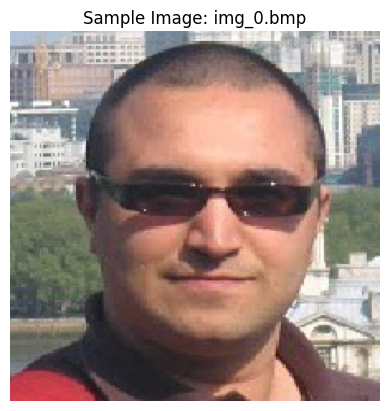

In [10]:
# Display One Sample Image
from tensorflow.keras.preprocessing.image import load_img

# Pick the first training sample
sample_path = train_df['file_path'].iloc[0]

# Resize to 224×224 for visualization
img = load_img(sample_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f"Sample Image: {os.path.basename(sample_path)}")
plt.axis('off')

### Section 1: Baseline CNN Model Training: EfficientNet B0–B7

##### Workflow:
- All 8 EfficientNet models (B0–B7) will be trained as baeline models using 5 epochs.
- Based on the model evaluation results, the best EfficientNet model will be selected and further fine tuned forfeature extraction  

In [11]:
# Baseline (no augmentation)
base_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

In [12]:
# Fine-tuning (with augmentation)
aug_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [13]:
# Regressor (no split, no augmentation)
reg_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [14]:
# Configuration for each variant
eff_configs = [
    (EfficientNetB0, 224), (EfficientNetB1, 240), (EfficientNetB2, 260),
    (EfficientNetB3, 300), (EfficientNetB4, 380), (EfficientNetB5, 456),
    (EfficientNetB6, 528), (EfficientNetB7, 600)
]

results = {}
for ModelClass, size in eff_configs:
    name = ModelClass.__name__
    print(f"\n--- Training baseline: {name} ({size}×{size}) ---")

    # Generators for this size
    train_gen = base_datagen.flow_from_dataframe(
        train_df, x_col='file_path', y_col='bmi',
        subset='training', target_size=(size,size),
        batch_size=32, class_mode='raw',
        shuffle=True, seed=SEED
    )
    val_gen = base_datagen.flow_from_dataframe(
        train_df, x_col='file_path', y_col='bmi',
        subset='validation', target_size=(size,size),
        batch_size=32, class_mode='raw',
        shuffle=False, seed=SEED
    )


--- Training baseline: EfficientNetB0 (224×224) ---
Found 2568 validated image filenames.
Found 642 validated image filenames.

--- Training baseline: EfficientNetB1 (240×240) ---
Found 2568 validated image filenames.
Found 642 validated image filenames.

--- Training baseline: EfficientNetB2 (260×260) ---
Found 2568 validated image filenames.
Found 642 validated image filenames.

--- Training baseline: EfficientNetB3 (300×300) ---
Found 2568 validated image filenames.
Found 642 validated image filenames.

--- Training baseline: EfficientNetB4 (380×380) ---
Found 2568 validated image filenames.
Found 642 validated image filenames.

--- Training baseline: EfficientNetB5 (456×456) ---
Found 2568 validated image filenames.
Found 642 validated image filenames.

--- Training baseline: EfficientNetB6 (528×528) ---
Found 2568 validated image filenames.
Found 642 validated image filenames.

--- Training baseline: EfficientNetB7 (600×600) ---
Found 2568 validated image filenames.
Found 642 val

In [36]:
# Build model
inp = Input(shape=(size,size,3))
base = ModelClass(include_top=False, input_tensor=inp, weights='imagenet')
base.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.2)(x)
out = Dense(1, activation='linear')(x)
model = Model(inp, out)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
model.fit(
    train_gen, validation_data=val_gen,
    epochs=5,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
    verbose=2
    )

# Evaluate
preds = model.predict(val_gen, verbose=0)
y_true = val_gen.labels

mse  = mean_squared_error(y_true, preds)
mae  = mean_absolute_error(y_true, preds)
corr = pearsonr(y_true, preds.ravel())[0]

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
81/81 - 151s - 2s/step - loss: 665.4985 - mae: 24.0288 - val_loss: 357.1710 - val_mae: 17.0818
Epoch 2/5
81/81 - 30s - 369ms/step - loss: 205.8406 - mae: 11.4698 - val_loss: 134.8240 - val_mae: 8.7778
Epoch 3/5
81/81 - 30s - 372ms/step - loss: 103.3180 - mae: 7.6077 - val_loss: 88.2514 - val_mae: 7.0378
Epoch 4/5
81/81 - 30s - 372ms/step - loss: 88.7043 - mae: 7.2325 - val_loss: 79.2609 - val_mae: 6.7491
Epoch 5/5
81/81 - 30s - 372ms/step - loss: 85.9120 - mae: 7.1936 - val_loss: 75.1519 - val_mae: 6.6089


In [37]:
# Extract learning rate
import tensorflow.keras.backend as K
lr = float(K.get_value(model.optimizer.learning_rate))

results[name] = {
    'lr'  : lr,
    'mse' : mse,
    'mae' : mae,
    'corr': corr
}

print(f"{name} → LR {lr:.5f}, MSE {mse:.2f}, MAE {mae:.2f}, Pearson r {corr:.3f}")

Ensemble → LR 0.00100, MSE 75.15, MAE 6.61, Pearson r 0.009


In [38]:
# Summarize
baseline_df = pd.DataFrame(results).T.sort_values('mse')
print("\nBaseline Results:")
display(baseline_df[['lr','mse','mae','corr']])


Baseline Results:


,lr,mse,mae,corr
Ensemble,0.001,75.151943,6.608854,0.008836


#### Model Selection:
- The **EfficientNetB6** has the highest Pearson -R statistic of 0.0925. Therefore, the model is picked for fine tuning.
- The EfficientNetB0 model has the lowest error (MSE ≈ 71.02, MAE ≈ 6.49).

### Section 2: Fine-Tuning the Best EfficientNet Model

##### Workflow:

##### The best performing EfficientNet Model is further fine tuned by implementing the following teatments:
- The last 30 layers of the base model are unforzen for fine tuning
- Data augmentation applied to increase the size and diversity of the training dataset due to a limited overall data set of only 4205 pictures. Various data augmentation treatments applied like rotation, width and height shifts, and others.
- The model was trained for 15 epochs to help observe convergence and determine the appropriate epochs for model training.
- The model's loss curve, over the 15 epochs, is plotted to provide a visualizatin of the flattening loss curve.    

### Section 1.2.1 Model & Augmentation Setup

In [18]:
# Model selection
ModelClass = EfficientNetB3
img_size = (300, 300)  # EfficientNetB3’s default input resolution
print(f"Fine-tuning EfficientNetB3 with input size {img_size}")

Fine-tuning EfficientNetB3 with input size (300, 300)


In [19]:
# Augmented generators
train_aug = aug_datagen.flow_from_dataframe(
    train_df, x_col='file_path', y_col='bmi',
    subset='training', target_size=img_size,
    batch_size=32, class_mode='raw',
    shuffle=True, seed=SEED
)
val_aug = aug_datagen.flow_from_dataframe(
    train_df, x_col='file_path', y_col='bmi',
    subset='validation', target_size=img_size,
    batch_size=32, class_mode='raw',
    shuffle=False, seed=SEED
)

Found 2568 validated image filenames.
Found 642 validated image filenames.


### Section 1.2.2 Build & Compile Fine-Tuned Model

In [20]:
# Build base & head
inp = Input(shape=img_size + (3,))
base = ModelClass(include_top=False, input_tensor=inp, weights='imagenet')

# Unfreeze last 30 layers
for layer in base.layers[-30:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.2)(x)
out = Dense(1, activation='linear')(x)
ft_model = Model(inp, out)

ft_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
ft_model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,785,072 (41.14 MB)

 Trainable params: 10,697,769 (40.81 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [21]:
history_ft = ft_model.fit(
    train_aug, validation_data=val_aug,
    epochs=15,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=2
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
81/81 - 2673s - 33s/step - loss: 189.8461 - mae: 10.0710 - val_loss: 245.3414 - val_mae: 13.8166
Epoch 2/15
81/81 - 66s - 810ms/step - loss: 41.5923 - mae: 4.8256 - val_loss: 106.3825 - val_mae: 9.0845
Epoch 3/15
81/81 - 65s - 806ms/step - loss: 34.4968 - mae: 4.4713 - val_loss: 68.1971 - val_mae: 6.8745
Epoch 4/15
81/81 - 65s - 808ms/step - loss: 29.4501 - mae: 4.0789 - val_loss: 56.7003 - val_mae: 6.2124
Epoch 5/15
81/81 - 65s - 806ms/step - loss: 25.5003 - mae: 3.8427 - val_loss: 68.7384 - val_mae: 6.8999
Epoch 6/15
81/81 - 66s - 813ms/step - loss: 23.9247 - mae: 3.7114 - val_loss: 40.1941 - val_mae: 5.1570
Epoch 7/15
81/81 - 66s - 809ms/step - loss: 21.2086 - mae: 3.5121 - val_loss: 32.5565 - val_mae: 4.5101
Epoch 8/15
81/81 - 66s - 812ms/step - loss: 17.5091 - mae: 3.2274 - val_loss: 55.8811 - val_mae: 5.8693
Epoch 9/15
81/81 - 65s - 807ms/step - loss: 17.5238 - mae: 3.1970 - val_loss: 37.2778 - val_mae: 4.5806
Epoch 10/15
81/81 - 66s - 809ms/step - loss: 15.0805 - mae:

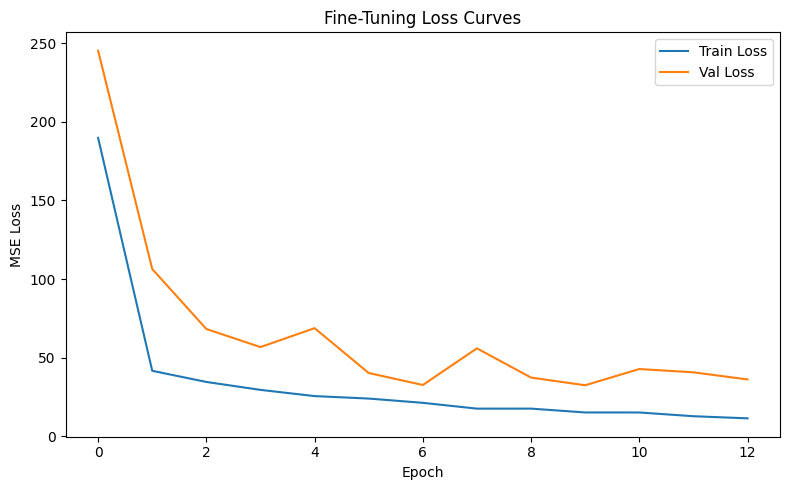

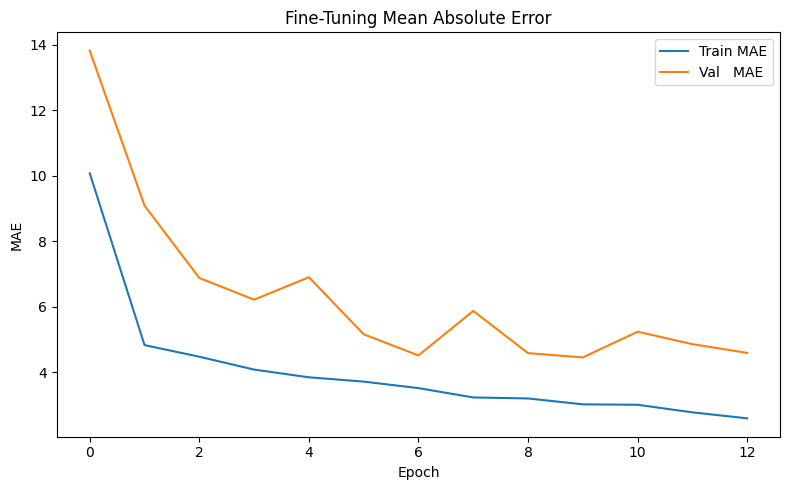

In [22]:
# Plot learning curves

# MSE loss curve
plt.figure(figsize=(8,5))
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Val Loss')
plt.title('Fine-Tuning Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.show()

# MAE curve
mae_key     = 'mae' if 'mae' in history_ft.history else 'mean_absolute_error'
val_mae_key = 'val_' + mae_key

plt.figure(figsize=(8,5))
plt.plot(history_ft.history[mae_key],     label='Train MAE')
plt.plot(history_ft.history[val_mae_key], label='Val   MAE')
plt.title('Fine-Tuning Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

### Section 2.1: Create Feature Extractor for Regressors

In [23]:
feature_extractor = Model(
    inputs=ft_model.input,
    # grab the layer just before the Dropout/Dense head (i.e. the GAP output)
    outputs=ft_model.layers[-3].output
)

In [24]:
# 2.1.2 Prepare generators for feature extraction
train_feat_gen = reg_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path', y_col='bmi',
    target_size=img_size,
    batch_size=32,
    class_mode='raw',
    shuffle=False,
    seed=SEED
)

test_feat_gen = reg_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path', y_col='bmi',
    target_size=img_size,
    batch_size=32,
    class_mode='raw',
    shuffle=False,
    seed=SEED
)

Found 3210 validated image filenames.
Found 752 validated image filenames.


In [25]:
# Extract features
X_train = feature_extractor.predict(train_feat_gen, verbose=0)
y_train = train_feat_gen.labels

X_test  = feature_extractor.predict(test_feat_gen, verbose=0)
y_test  = test_feat_gen.labels

In [26]:
from sklearn.impute import SimpleImputer

# Append the gender feature
g_train = train_df['gender_binary'].values.reshape(-1,1)
g_test  = test_df['gender_binary'].values.reshape(-1,1)

X_train = np.hstack([X_train, g_train])
X_test  = np.hstack([X_test,  g_test])

# Impute any NaNs with the column‐mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test  = imputer.transform(X_test)

print("After imputation:", X_train.shape, X_test.shape)

After imputation: (3210, 1537) (752, 1537)


### Section 2.2: Train & Evaluate Regressors

In [27]:
# sanity check
import numpy as np
print("NaNs in train:", np.isnan(X_train).sum(),
      "   NaNs in test:", np.isnan(X_test).sum())

NaNs in train: 0    NaNs in test: 0


In [29]:
# Define models
regressors = {
    'XGB'          : XGBRegressor(n_estimators=100, random_state=42),
    'Ridge'        : Ridge(),
    'RandomForest' : RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR'          : SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'KNN'          : KNeighborsRegressor(n_neighbors=5),
    'MLP'          : MLPRegressor(
                         hidden_layer_sizes=(100,),
                         activation='relu',
                         solver='adam',
                         max_iter=200,
                         random_state=42
                     ),
    'LightGBM'     : LGBMRegressor(n_estimators=100, random_state=42),
    'CatBoost'     : CatBoostRegressor(
                         iterations=100,
                         learning_rate=0.1,
                         verbose=0,
                         random_state=42
                     )
}

metrics = {}
for name, model in regressors.items():
    print(f"\nTraining {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    corr = pearsonr(y_test, preds)[0]
    metrics[name] = {'MSE': mse, 'MAE': mae, 'Pearson_r': corr}
    print(f"{name} → MSE {mse:.2f}, MAE {mae:.2f}, Pearson r {corr:.3f}")

metrics_df = pd.DataFrame(metrics).T
display(metrics_df)


Training XGB
XGB → MSE 49.50, MAE 4.83, Pearson r 0.657

Training Ridge
Ridge → MSE 48.15, MAE 4.77, Pearson r 0.667

Training RandomForest
RandomForest → MSE 47.35, MAE 4.73, Pearson r 0.673

Training SVR
SVR → MSE 49.76, MAE 4.89, Pearson r 0.655

Training KNN
KNN → MSE 50.04, MAE 4.89, Pearson r 0.649

Training MLP
MLP → MSE 51.03, MAE 4.90, Pearson r 0.650

Training LightGBM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391682
[LightGBM] [Info] Number of data points in the train set: 3210, number of used features: 1537
[LightGBM] [Info] Start training from score 32.434370


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM → MSE 48.67, MAE 4.78, Pearson r 0.662

Training CatBoost
CatBoost → MSE 48.50, MAE 4.76, Pearson r 0.665


,MSE,MAE,Pearson_r
XGB,49.504089,4.826246,0.657164
Ridge,48.152859,4.769733,0.666588
RandomForest,47.349301,4.726451,0.672873
SVR,49.756356,4.888632,0.655373
KNN,50.043076,4.893229,0.649358
MLP,51.028533,4.899735,0.650048
LightGBM,48.668817,4.782210,0.662307
CatBoost,48.499762,4.761218,0.664801


In [30]:
def per_gender_metrics(model, X, y, genders, labels=('Female','Male')):
    """
    Compute MSE, MAE and Pearson r for each gender.
    genders: 1D array of 0 (Female) / 1 (Male).
    Returns a DataFrame indexed by gender labels.
    """
    results = {}
    preds = model.predict(X)
    for label, code in zip(labels, [0,1]):
        mask = (genders == code)
        if not mask.any():
            results[label] = {'MSE': np.nan, 'MAE': np.nan, 'Pearson_r': np.nan}
            continue

        y_true = y[mask]
        y_pred = preds[mask]
        results[label] = {
            'MSE'      : mean_squared_error(y_true, y_pred),
            'MAE'      : mean_absolute_error(y_true, y_pred),
            'Pearson_r': pearsonr(y_true, y_pred)[0]
        }
    return pd.DataFrame(results).T

# apply to each regressor
gender_array = test_df['gender_binary'].values

for name, model in regressors.items():
    print(f"\n{name}")
    display(
        per_gender_metrics(model, X_test, y_test, gender_array)
          .style
          .format("{:.2f}")
          .set_caption(f"Metrics for {name} by Gender")
    )


XGB


,MSE,MAE,Pearson_r
Female,55.22,4.93,0.63
Male,45.15,4.75,0.68



Ridge


,MSE,MAE,Pearson_r
Female,52.82,4.89,0.65
Male,44.60,4.68,0.68



RandomForest


,MSE,MAE,Pearson_r
Female,52.09,4.89,0.65
Male,43.74,4.60,0.69



SVR


,MSE,MAE,Pearson_r
Female,53.84,5.00,0.64
Male,46.65,4.80,0.67



KNN


,MSE,MAE,Pearson_r
Female,55.39,5.04,0.63
Male,45.97,4.78,0.67



MLP


,MSE,MAE,Pearson_r
Female,55.38,5.00,0.64
Male,47.72,4.83,0.66



LightGBM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MSE,MAE,Pearson_r
Female,53.27,4.90,0.64
Male,45.17,4.69,0.68



CatBoost


,MSE,MAE,Pearson_r
Female,53.63,4.90,0.64
Male,44.60,4.66,0.68


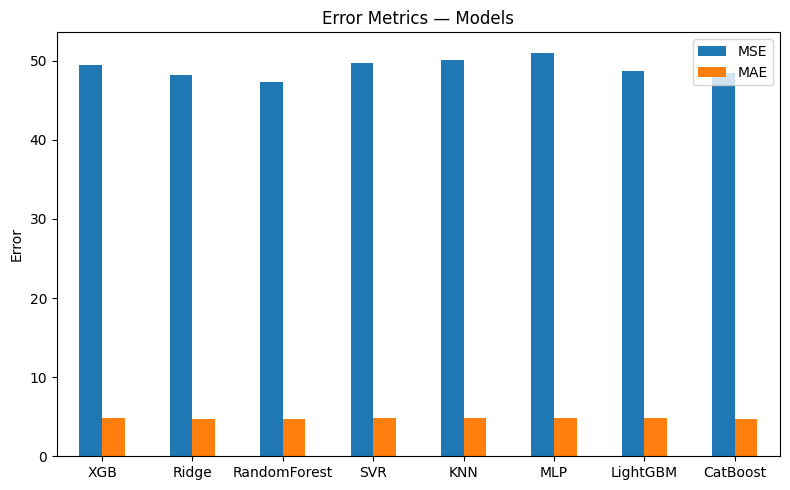

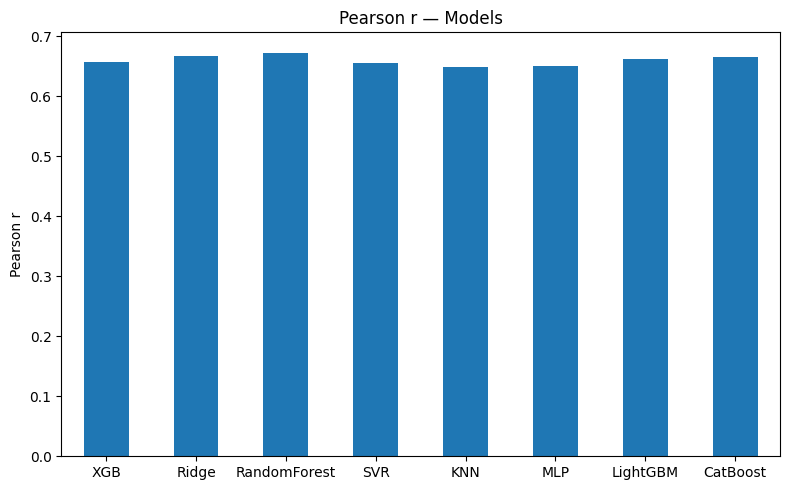

In [32]:
# Visualize Error Comparison
metrics_df[['MSE','MAE']].plot.bar(
    figsize=(8,5), rot=0, title='Error Metrics — Models'
)
plt.ylabel('Error')
plt.tight_layout()
plt.show()

# Visualize Pearson r Comparison
metrics_df['Pearson_r'].plot.bar(
    figsize=(8,5), rot=0, title='Pearson r — Models'
)
plt.ylabel('Pearson r')
plt.tight_layout()
plt.show()

### Section 2.3: Ensemble of Top 3 Regressors

XGB          | MSE: 49.504 | MAE: 4.826 | r: 0.657
Ridge        | MSE: 48.153 | MAE: 4.770 | r: 0.667
RandomForest | MSE: 47.349 | MAE: 4.726 | r: 0.673
SVR          | MSE: 49.756 | MAE: 4.889 | r: 0.655
KNN          | MSE: 50.043 | MAE: 4.893 | r: 0.649
MLP          | MSE: 51.029 | MAE: 4.900 | r: 0.650
LightGBM     | MSE: 48.669 | MAE: 4.782 | r: 0.662
CatBoost     | MSE: 48.500 | MAE: 4.761 | r: 0.665
Ensemble     | MSE: 47.763 | MAE: 4.732 | r: 0.670


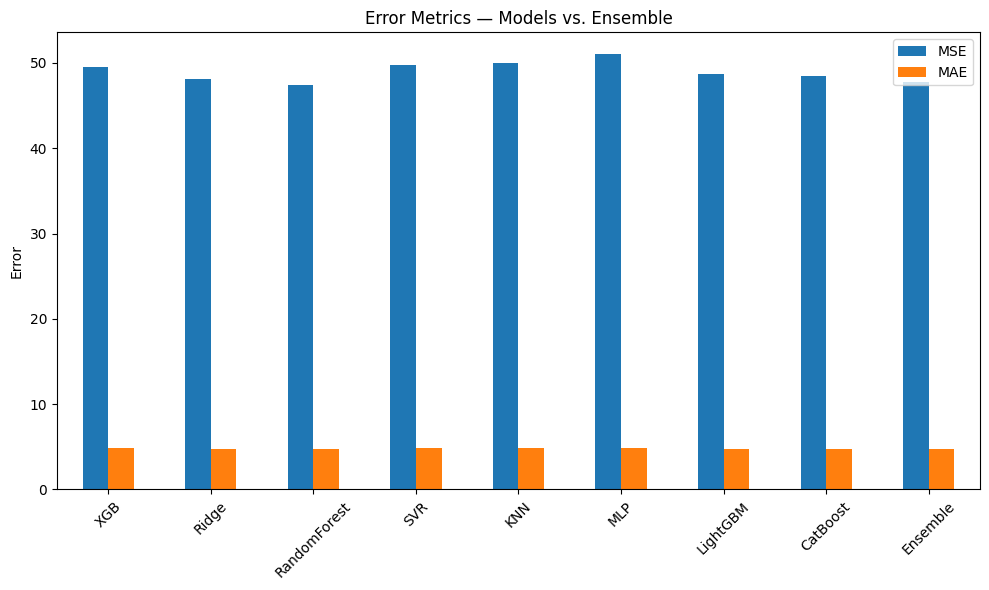

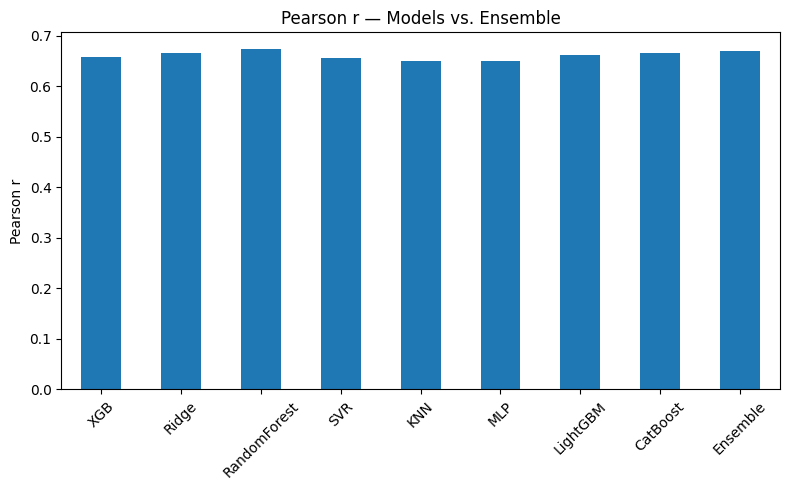

In [33]:
# Pick the three regressors with lowest MSE
top_three = metrics_df.nsmallest(3, 'MSE').index.tolist()

# Build & fit a VotingRegressor on those
ens = VotingRegressor([(nm, regressors[nm]) for nm in top_three])
ens.fit(X_train, y_train)

# Evaluate ensemble
y_ens = ens.predict(X_test)
ens_metrics = {
    'MSE':        mean_squared_error(y_test, y_ens),
    'MAE':        mean_absolute_error(y_test, y_ens),
    'Pearson_r':  pearsonr(y_test, y_ens)[0]
}

# Add to your metrics table
metrics_df.loc['Ensemble'] = ens_metrics

# Print a nice summary
for name, vals in metrics_df.iterrows():
    print(f"{name:12s} | MSE: {vals['MSE']:.3f} | MAE: {vals['MAE']:.3f} | r: {vals['Pearson_r']:.3f}")

# Visualize error comparison (individual vs. ensemble)
metrics_df[['MSE','MAE']].plot.bar(
    figsize=(10,6), rot=45,
    title='Error Metrics — Models vs. Ensemble'
)
plt.ylabel('Error')
plt.tight_layout()
plt.show()

# Visualize correlation comparison
metrics_df['Pearson_r'].plot.bar(
    figsize=(8,5), rot=45,
    title='Pearson r — Models vs. Ensemble'
)
plt.ylabel('Pearson r')
plt.tight_layout()
plt.show()

In [40]:
# Save file

import tensorflow as tf

# Define the output path
pkl_path = "EfficientNetB3_lrsched_bmi_model_quant.pkl"

#Create the converter from your trained Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Optional) enable default optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model to raw TFLite bytes
tflite_model = converter.convert()

# Write the raw TFLite bytes to disk
with open(pkl_path, "wb") as f:
    f.write(tflite_model)

# Confirm
print(f"✅ Pickled TFLite bytes to {pkl_path}")

Saved artifact at '/tmp/tmpqljx5qrd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 600, 600, 3), dtype=tf.float32, name='keras_tensor_388')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134141972439184: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134141972440528: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134150291165776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134150245142544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134150291167504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134150291169232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134150291168080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134150245141968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134146733447056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134146733448016: TensorSpec(shape=(), dtype=tf.resource, name=